In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import math
import sys
import re
import statistics
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import lightgbm as lgb
import simple_lightGBM

In [2]:
from Kidera import kidera

In [3]:
df = pd.read_csv('data/DDG_Dataset.csv')
# df = pd.read_csv('data/DDG_Dataset_mini.csv')
df = df[df['Temperature'] != "'-"].reset_index(drop=True)
df['Temperature'] = df['Temperature'].astype('float64')
ndatas = df.shape[0]
print(df.columns)
print(ndatas)
df

Index(['Rowid', 'ID', 'Protein Name', 'Mutation', 'Chain', 'PDB',
       'Temperature', 'pH', 'ΔΔG', 'Reference', 'A', 'R', 'N', 'D', 'C', 'Q',
       'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V',
       'ASP', 'PHE', 'GLN', 'LYS', 'ILE', 'TYR', 'GLY', 'ASN', 'ARG', 'LEU',
       'TRP', 'ALA', 'THR', 'VAL', 'HIS', 'CYS', 'GLU', 'MET', 'PRO', 'SER'],
      dtype='object')
8535


,Rowid,ID,Protein Name,Mutation,Chain,PDB,Temperature,pH,ΔΔG,Reference,...,TRP,ALA,THR,VAL,HIS,CYS,GLU,MET,PRO,SER
0,1,1,Tryptophan synthase alpha chain,E49M,A,1WQ5,298.95,7.0,4.60,PMID: 378988,...,0.0,4.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0
1,2,2,Tryptophan synthase alpha chain,E49Q,A,1WQ5,298.95,7.0,-2.50,PMID: 378988,...,0.0,4.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0
2,3,3,Endolysin,W138Y,A,2LZM,298.15,2.2,-1.71,PMID: 911878,...,0.0,5.0,4.0,4.0,0.0,0.0,2.0,2.0,1.0,2.0
3,4,6,Cellular tumor antigen p53,C242S,A,1TUP,283.15,7.2,-3.07,PMID: 1203434,...,0.0,0.0,0.0,1.0,2.0,4.0,2.0,3.0,1.0,2.0
4,5,7,Cellular tumor antigen p53,F134L,A,1TUP,283.15,7.2,-4.78,PMID: 1203434,...,0.0,2.0,5.0,3.0,0.0,5.0,4.0,1.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8530,8570,13318,Transcriptional repressor arc,V25A,A,1ARR,298.15,7.5,-0.40,PMID: 7664079,...,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,1.0
8531,8571,13319,Transcriptional repressor arc,V18A,A,1ARR,298.15,7.5,-0.50,PMID: 7664079,...,1.0,1.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,0.0
8532,8572,13320,Transcriptional repressor arc,V33A,A,1ARR,298.15,7.5,-2.10,PMID: 7664079,...,1.0,1.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,2.0
8533,8573,13321,Transcriptional repressor arc,S32A,A,1ARR,298.15,7.5,-3.80,PMID: 7664079,...,0.0,1.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.0


In [4]:
kidera.symbol_lookup
kidera_table = pd.read_csv('Kidera/kidera.csv', header=None).set_index(0)
kidera_table

,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
ALA,-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.20,-0.08,0.21,-0.48
ARG,0.22,1.27,1.37,1.87,-1.70,0.46,0.92,-0.39,0.23,0.93
ASN,1.14,-0.07,-0.12,0.81,0.18,0.37,-0.09,1.23,1.10,-1.73
ASP,0.58,-0.22,-1.58,0.81,-0.92,0.15,-1.52,0.47,0.76,0.70
CYS,0.12,-0.89,0.45,-1.05,-0.71,2.41,1.52,-0.69,1.13,1.10
GLN,-0.47,0.24,0.07,1.10,1.10,0.59,0.84,-0.71,-0.03,-2.33
GLU,-1.45,0.19,-1.61,1.17,-1.31,0.40,0.04,0.38,-0.35,-0.12
GLY,1.46,-1.96,-0.23,-0.16,0.10,-0.11,1.32,2.36,-1.66,0.46
HIS,-0.41,0.52,-0.28,0.28,1.61,1.01,-1.85,0.47,1.13,1.63


In [5]:
%%time 
around_acid = np.zeros((ndatas, 10))
for index, row in df.iterrows():
    # print(index)
    # print(row)
    for acid, r in kidera_table.iterrows():
        # print(acid)
        # print(r)
        # print(row[acid])
        # print(row[acid] * r)
        around_acid[index, :] += row[acid] * r
        # break
    # break
    
around_acid

CPU times: user 36.7 s, sys: 99.7 ms, total: 36.8 s
Wall time: 37 s


array([[-11.27, -15.66,  15.32, ...,   3.88,   6.42,  -5.23],
       [-11.27, -15.66,  15.32, ...,   3.88,   6.42,  -5.23],
       [ -6.78,  -6.53,   6.59, ...,   0.97,   2.29,  -6.09],
       ...,
       [ -5.25,  -0.13,   5.73, ...,   1.19,  -3.48,   1.  ],
       [ -2.96,  -2.31,   5.41, ...,   4.96,  -1.61,  -3.84],
       [-17.09, -19.41,  -7.  , ..., -11.25,   1.04,   4.88]])

In [6]:
data_df = df.drop(columns=['Rowid', 'ID', 'Protein Name', 'Mutation', 'Chain', 'PDB', 'ΔΔG', 'Reference'])
data_x = data_df.to_numpy()
data_x = np.concatenate([data_x, around_acid], 1)
data_y = df['ΔΔG'].to_numpy()
data_x

array([[298.95,   7.  ,   0.  , ...,   3.88,   6.42,  -5.23],
       [298.95,   7.  ,   0.  , ...,   3.88,   6.42,  -5.23],
       [298.15,   2.2 ,   0.  , ...,   0.97,   2.29,  -6.09],
       ...,
       [298.15,   7.5 ,   1.  , ...,   1.19,  -3.48,   1.  ],
       [298.15,   7.5 ,   1.  , ...,   4.96,  -1.61,  -3.84],
       [293.15,   8.5 ,   0.  , ..., -11.25,   1.04,   4.88]])

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
pred_y = np.zeros(ndatas)
feature_importance = np.zeros(data_x.shape[1])
for index, (train_indices, valid_indices) in enumerate(kf.split(range(ndatas))):
    print(index)
    print(train_indices)
    print(valid_indices)
    train_x, test_x = data_x[train_indices], data_x[valid_indices] 
    train_y = data_y[train_indices]
    pred_y[valid_indices], importances = simple_lightGBM.predict(train_x, train_y, test_x)
    feature_importance += importances

0
[   0    3    4 ... 8532 8533 8534]
[   1    2    5 ... 8525 8530 8531]
1
[   1    2    3 ... 8531 8532 8534]
[   0    8    9 ... 8502 8511 8533]
2
[   0    1    2 ... 8531 8532 8533]
[  12   20   27 ... 8522 8527 8534]
3
[   0    1    2 ... 8532 8533 8534]
[   4   13   17 ... 8526 8528 8529]
4
[   0    1    2 ... 8531 8533 8534]
[   3    7   10 ... 8521 8524 8532]


In [8]:
df['pred_ΔΔG'] = pred_y
df.to_csv('data/pred_DDG_Dataset_lightGBM_Kidera.csv')

In [11]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df['ΔΔG'], df['pred_ΔΔG']))

2.487644687961437


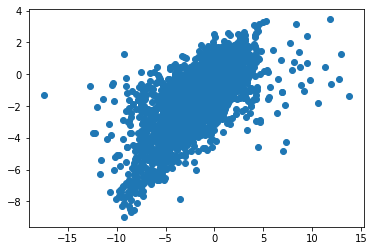

In [9]:
plt.scatter(df['ΔΔG'], df['pred_ΔΔG'])

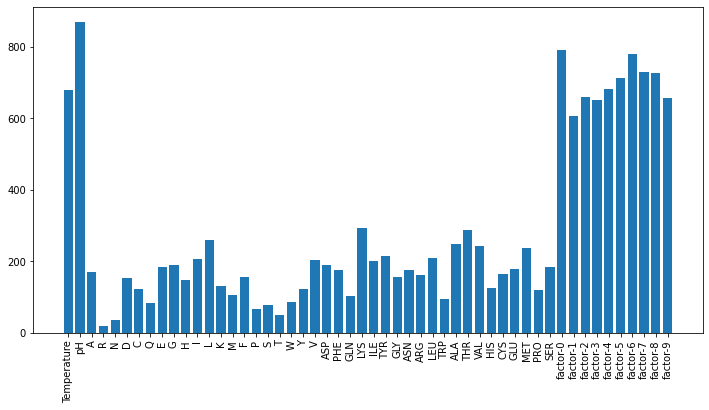

In [10]:
plt.figure(figsize=(12.0, 6.0))
columns = list(data_df.columns)
columns.extend(['factor-{}'.format(i) for i in range(10)])
plt.bar(columns, feature_importance)
plt.xticks(rotation=90)
plt.show()